In [4]:
import time
import io
import imageio.v2 as imageio
from datetime import datetime
from neo4j import GraphDatabase
from neo4j.graph import Node, Relationship
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colormaps


def read_cypher_query(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()


def export_neo4j_graph(uri, user, password, cypher_query):
    driver = GraphDatabase.driver(uri, auth=(user, password))
    nodes_dict = {}
    edges = []

    with driver.session() as session:
        result = session.run(cypher_query)
        for record in result:
            for value in record.values():
                if isinstance(value, Node):
                    full_id = value.element_id
                    short_id = full_id.split(":")[-1]
                    label_group = list(value.labels)
                    group = label_group[0] if label_group else "Node"
                    label = f"{group}\n{short_id}"

                    nodes_dict[full_id] = {
                        "id": full_id,
                        "label": label,
                        "title": label,
                        "group": group
                    }

                elif isinstance(value, Relationship):
                    edges.append({
                        "from": value.start_node.element_id,
                        "to": value.end_node.element_id,
                        "label": value.type
                    })

    driver.close()
    return {
        "nodes": list(nodes_dict.values()),
        "edges": edges
    }


def render_graph_to_array(graph_data):
    G = nx.DiGraph()
    group_list = sorted(set(node.get('group', 'default') for node in graph_data['nodes']))
    cmap = colormaps['tab10']
    group_to_color = {group: cmap(i / len(group_list)) for i, group in enumerate(group_list)}

    for node in graph_data['nodes']:
        G.add_node(node['id'], label=node.get('label', str(node['id'])), group=node.get('group', 'default'))
    for edge in graph_data['edges']:
        G.add_edge(edge['from'], edge['to'], label=edge.get('label', ''))

    # ✅ Use kamada_kawai layout
    pos = nx.kamada_kawai_layout(G)

    node_colors = [group_to_color[G.nodes[n]['group']] for n in G.nodes]
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes}

    fig, ax = plt.subplots(figsize=(12, 10))
    nx.draw(G, pos,
            labels=node_labels,
            node_size=1000,
            node_color=node_colors,
            edge_color='gray',
            font_size=8,
            font_weight='normal',
            linewidths=1,
            with_labels=True,
            ax=ax)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, ax=ax)

    for group, color in group_to_color.items():
        ax.scatter([], [], c=[color], label=group, s=100)
    ax.legend(title="Groups", loc='upper right', fontsize=8, title_fontsize=9)
    ax.set_title("Graph Snapshot", fontsize=12)
    ax.axis('off')
    fig.tight_layout()

    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=150)
    plt.close(fig)
    buf.seek(0)

    image = imageio.imread(buf)
    buf.close()
    return image


def create_gif_from_arrays(image_arrays, output_gif, duration=1.5):
    # ✅ loop=0 for infinite playback
    imageio.mimsave(output_gif, image_arrays, duration=duration, loop=0)
    print(f"🎞 GIF saved to {output_gif}")


def run_logging_loop(
    uri, user, password,
    query_file, repeat_count=5, wait_seconds=10,
    gif_path="graph_animation.gif"
):
    query = read_cypher_query(query_file)
    frames = []

    for i in range(repeat_count):
        print(f"🔁 Iteration {i+1}/{repeat_count}")
        graph_data = export_neo4j_graph(uri, user, password, query)
        frame = render_graph_to_array(graph_data)
        frames.append(frame)

        if i < repeat_count - 1:
            print(f"⏳ Waiting {wait_seconds} seconds...")
            time.sleep(wait_seconds)

    create_gif_from_arrays(frames, gif_path)


# === ✨ Example Run ===
if __name__ == "__main__":
    run_logging_loop(
        uri="bolt://localhost:7687",
        user="neo4j",
        password="12345678",
        query_file="query.cypher",
        repeat_count=35,
        wait_seconds=0.2,
        gif_path="graph_animation.gif"
    )


🔁 Iteration 1/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 2/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 3/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 4/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 5/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 6/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 7/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 8/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 9/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 10/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 11/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 12/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 13/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 14/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 15/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 16/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 17/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 18/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 19/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 20/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 21/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 22/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 23/50
⏳ Waiting 0.5 seconds...
🔁 Iteration 24/50
⏳ 

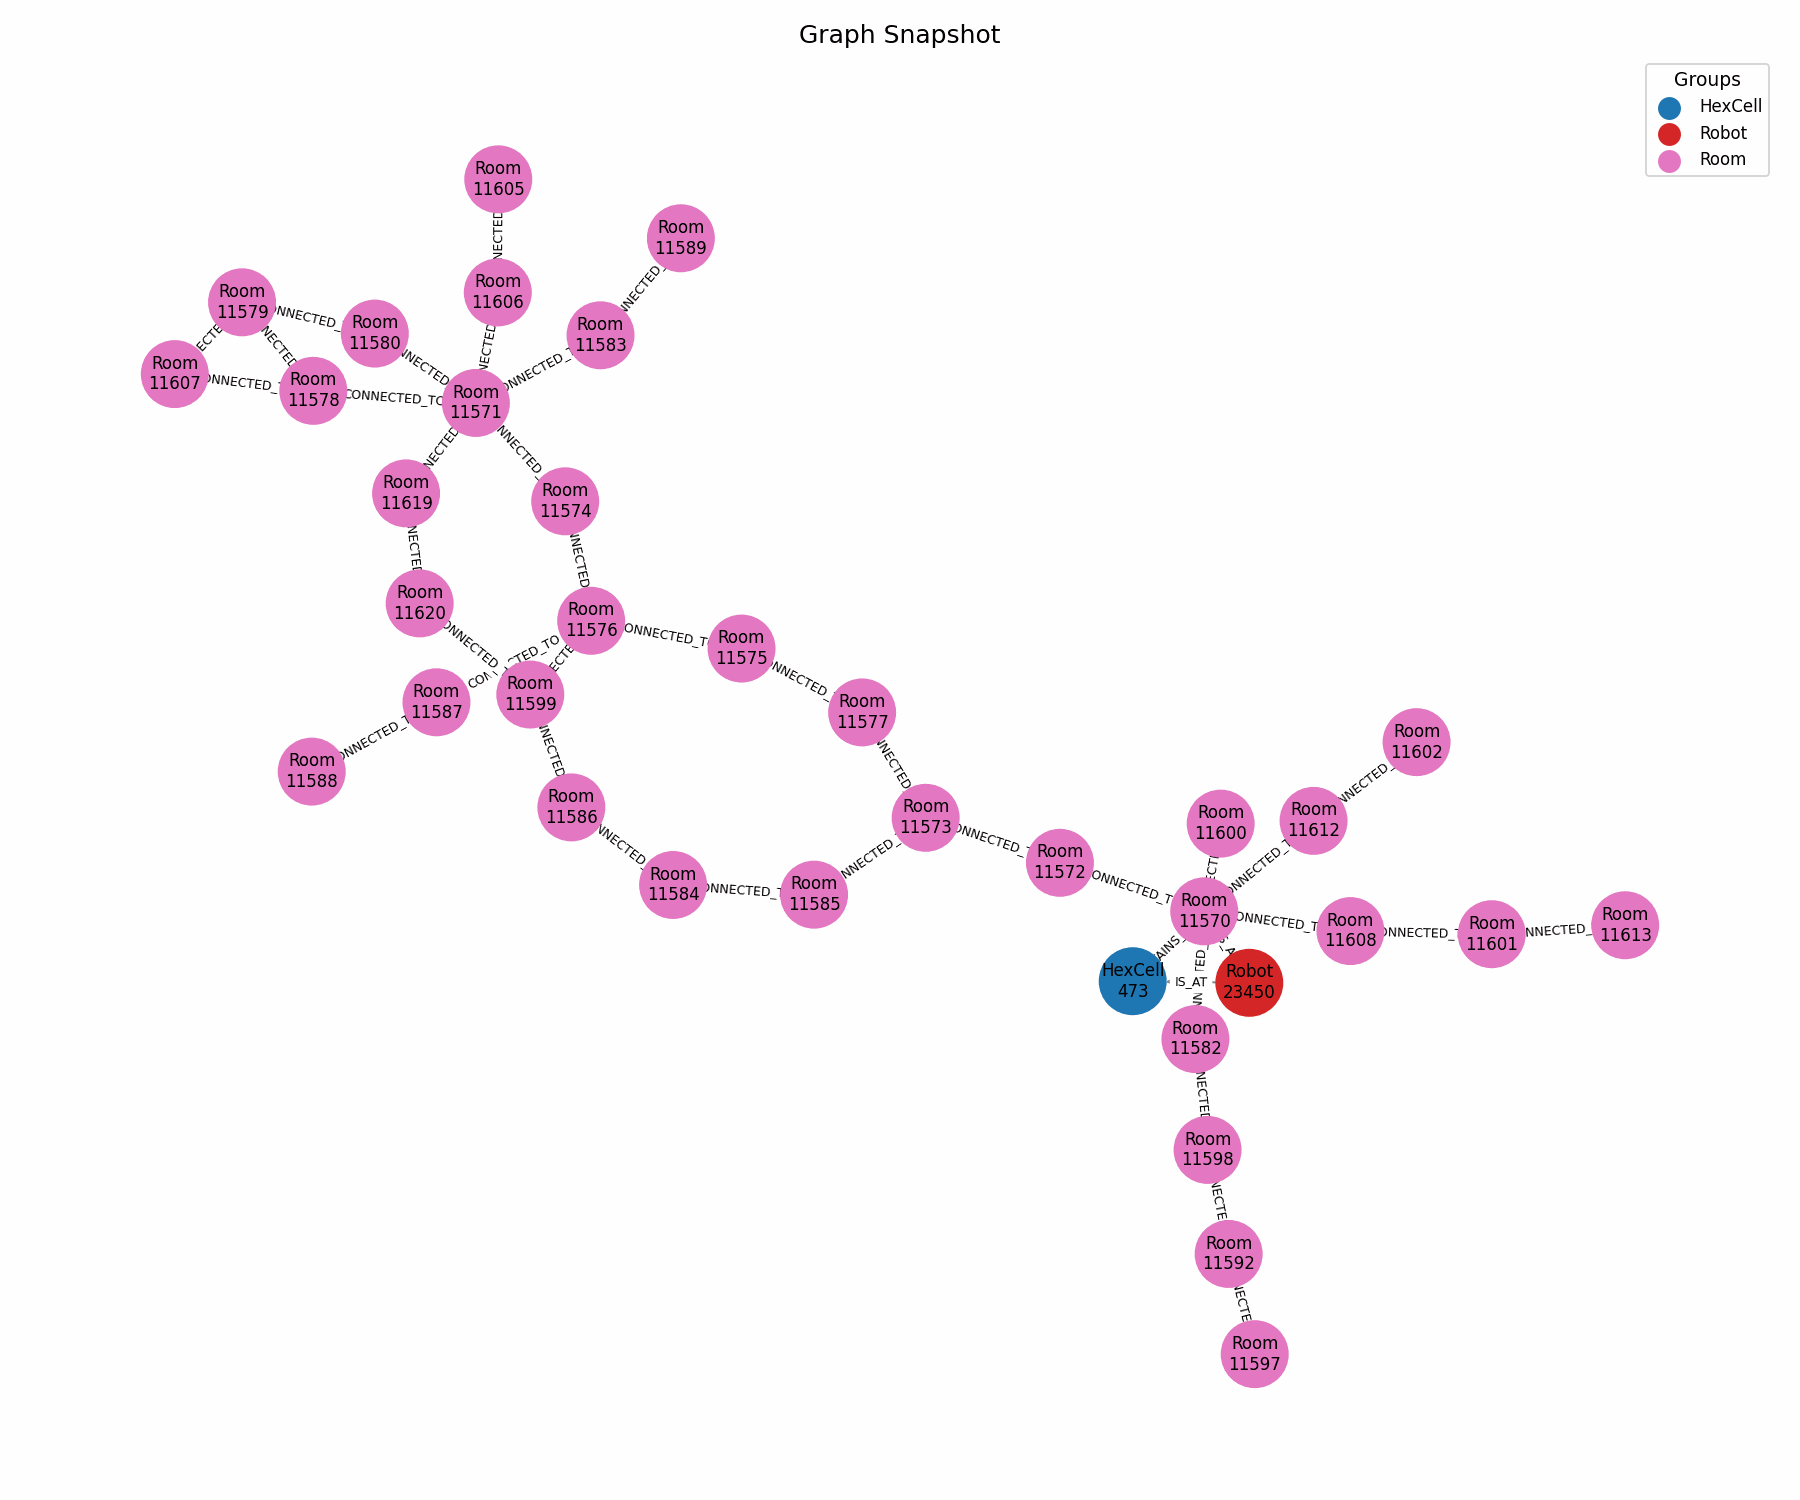

In [6]:
from IPython.display import Image
Image(filename="graph_animation.gif")